# Backpack Prediction Challenge

## Importing libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna as op
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np

c:\Users\ferna\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading the Data

We have 3 datasets, the train set, the test set (without the target), and an extra train set. Let's take a look to them.

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_extra_df = pd.read_csv('training_extra.csv')

In [19]:
train_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


In [20]:
test_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953
...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769153


In [5]:
train_extra_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461
...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3694316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


# Preparing the data

Let's start by joining both training sets.

In [6]:
train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

Now let's check it out if there are null values on our sets.

In [7]:
train_df.isnull().sum()

id                           0
Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [8]:
test_df.isna().sum()

id                         0
Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Indeed, they are. So, one approach could be just dropping them. However, since we wanna upload our submissions to Kaggle, and we are required to upload the predictions for the whole test set, we cannot do that. So we gotta find another alternative. By now, let's just drop the id column and look closer to the different features we got.

In [9]:
train_df = train_df.drop(columns='id')
test_df = test_df.drop(columns='id')

In [10]:
ft = [c for c in train_df.columns if not c == 'Price'] 

In [11]:
for features in ft:
    print(f' Value counts for {features}: \n {train_df[features].value_counts(dropna=False)}')

 Value counts for Brand: 
 Brand
Under Armour    801035
Adidas          797000
Nike            764407
Puma            755778
Jansport        749340
NaN             126758
Name: count, dtype: int64
 Value counts for Material: 
 Material
Polyester    1060882
Leather       976186
Nylon         942656
Canvas        903632
NaN           110962
Name: count, dtype: int64
 Value counts for Size: 
 Size
Medium    1354487
Large     1312295
Small     1239751
NaN         87785
Name: count, dtype: int64
 Value counts for Compartments: 
 Compartments
1.0     423577
4.0     417246
2.0     408150
3.0     406796
7.0     400824
5.0     399418
9.0     398192
10.0    396303
8.0     383172
6.0     360640
Name: count, dtype: int64
 Value counts for Laptop Compartment: 
 Laptop Compartment
Yes    1972937
No     1922848
NaN      98533
Name: count, dtype: int64
 Value counts for Waterproof: 
 Waterproof
Yes    1969205
No     1930789
NaN      94324
Name: count, dtype: int64
 Value counts for Style: 
 Style
Mess

In order to train the null values, we need to know exactly which type of data is each feature.

In [12]:
for features in ft:
    print(f'{features} is {train_df[features].dtype}')

Brand is object
Material is object
Size is object
Compartments is float64
Laptop Compartment is object
Waterproof is object
Style is object
Color is object
Weight Capacity (kg) is float64


For the categorical features, we are just going to let them as they are and give the work of handling them to our model. We just need to ensure they're considerer as actually null.

In [13]:
for f in ft:
    if train_df[f].dtype=="object":
        train_df[f] = train_df[f].fillna("NaN")
        test_df[f] = test_df[f].fillna("NaN")

In [14]:
test_df.isna().sum()

Brand                    0
Material                 0
Size                     0
Compartments             0
Laptop Compartment       0
Waterproof               0
Style                    0
Color                    0
Weight Capacity (kg)    77
dtype: int64

Now, learning through Kaggle, found this pretty feature engineering function, so credits to the one that made it.

In [15]:
def perform_feature_engineering(df):
    # Brand Material Interaction - Certain materials may be common for specific brands
    df['Brand_Material'] = df['Brand'] + '_' + df['Material']

    # Brand & Size Interaction - Some brands may produce only specific sizes
    df['Brand_Size'] = df['Brand'] + '_' + df['Size']


    # Compartments Binning - Group compartments into categories
    df['Compartments_Category'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])

    # Weight Capacity Ratio - Normalize weight capacity using the max value
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    # Interaction Feature: Weight vs. Compartments - Some bags may hold more with less compartments
    df['Weight_to_Compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)  # Avoid division by zero

    # Style and Size Interaction - Certain styles may correlate with sizes
    df['Style_Size'] = df['Style'] + '_' + df['Size']

    return df

# Apply the function to the training data
train_df= perform_feature_engineering(train_df)

# Apply the function to the test data
test_df = perform_feature_engineering(test_df)

Now, notice we have two features which consists of Yes and No (and null values), so we are going to make them boolean so our model can interpret them better. (If we map the Yes and No to 1 and 0 for example, the model might interpret as quantities, something we don't want.)

In [16]:
boolean_nft = ['Laptop Compartment', 'Waterproof']

In [17]:
for boolean in boolean_nft:
    train_df[boolean] = train_df[boolean].map({'Yes': True, 'No': False, 'NaN': pd.NA})
    train_df[boolean] = train_df[boolean].astype('boolean')
    test_df[boolean] = test_df[boolean].map({'Yes': True, 'No': False, 'NaN': pd.NA})
    test_df[boolean] = test_df[boolean].astype('boolean')

In [18]:
train_df['Laptop Compartment'].dtype

BooleanDtype

Now, in order to fill the null values of the numerical features, we are gonna use the mean of the feature.

In [19]:
print(train_df['Weight Capacity (kg)'].min())
print(train_df['Weight Capacity (kg)'].max())

5.0
30.0


In [20]:
train_df['Weight Capacity (kg)'] = train_df['Weight Capacity (kg)'].fillna(train_df['Weight Capacity (kg)'].mean()) 
test_df['Weight Capacity (kg)'] = test_df['Weight Capacity (kg)'].fillna(test_df['Weight Capacity (kg)'].mean()) 

In [21]:
train_df.isna().sum()

Brand                         0
Material                      0
Size                          0
Compartments                  0
Laptop Compartment        98533
Waterproof                94324
Style                         0
Color                         0
Weight Capacity (kg)          0
Price                         0
Brand_Material                0
Brand_Size                    0
Compartments_Category         0
Weight_Capacity_Ratio      1808
Weight_to_Compartments     1808
Style_Size                    0
dtype: int64

In [22]:
test_df.isna().sum()

Brand                        0
Material                     0
Size                         0
Compartments                 0
Laptop Compartment        4962
Waterproof                4811
Style                        0
Color                        0
Weight Capacity (kg)         0
Brand_Material               0
Brand_Size                   0
Compartments_Category        0
Weight_Capacity_Ratio       77
Weight_to_Compartments      77
Style_Size                   0
dtype: int64

Now is time to encode our features. We can take different approaches. In this case, we are gonna use OneHot. As we will see later, this might make the dimensionality a bit problematic. However, in this case we are just going to use Optuna with less trials.

In [ ]:
ft_n_bool = [f for f in train_df.columns if f not in ['id', 'Laptop Compartment', 'Waterproof'] and train_df[f].dtype == 'object']
ft_n_bool

['Brand',
 'Material',
 'Size',
 'Style',
 'Color',
 'Brand_Material',
 'Brand_Size',
 'Style_Size']

In [ ]:
combined = pd.concat([train_df,test_df],axis=0,ignore_index=True)

combined = pd.get_dummies(combined, columns=ft_n_bool ,dtype=float)
    
train_df_imp = combined.iloc[:len(train_df)].copy()
test_df_imp= combined.iloc[len(train_df):].reset_index(drop=True).copy()
test_df_imp = test_df_imp.drop(columns='Price')

In [133]:
train_df_imp

,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Price,Compartments_Category,Weight_Capacity_Ratio,Weight_to_Compartments,Brand_Adidas,Brand_Jansport,...,Style_Size_Messenger_NaN,Style_Size_Messenger_Small,Style_Size_NaN_Large,Style_Size_NaN_Medium,Style_Size_NaN_NaN,Style_Size_NaN_Small,Style_Size_Tote_Large,Style_Size_Tote_Medium,Style_Size_Tote_NaN,Style_Size_Tote_Small
0,7.0,True,False,11.611723,112.15875,Many,0.387057,1.451465,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10.0,True,True,27.078537,68.88056,Many,0.902618,2.461685,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,True,False,16.643760,39.17320,Few,0.554792,5.547920,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,True,False,12.937220,80.60793,Many,0.431241,1.437469,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,True,True,17.749338,86.02312,Few,0.591645,8.874669,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994313,3.0,True,True,28.098120,104.74460,Moderate,0.936604,7.024530,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994314,10.0,True,True,17.379531,122.39043,Many,0.579318,1.579957,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3994315,10.0,False,False,17.037708,148.18470,Many,0.567924,1.548883,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994316,2.0,False,False,28.783339,22.32269,Few,0.959445,9.594446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
test_df_imp

,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Brand_Adidas,Brand_Jansport,Brand_NAN,Brand_Nike,Brand_Puma,Brand_Under Armour,...,Style_Messenger,Style_NAN,Style_Tote,Color_Black,Color_Blue,Color_Gray,Color_Green,Color_NAN,Color_Pink,Color_Red
0,2.0,False,False,20.671147,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7.0,False,True,13.564105,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.0,False,True,11.809799,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,True,False,18.477036,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2.0,True,True,9.907953,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2.0,True,False,7.383498,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
199996,9.0,False,True,6.058394,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
199997,9.0,False,True,26.890163,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
199998,10.0,True,False,25.769153,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Training the model

Now, let's divide our "train" set and see what can we cook.

In [135]:
X = train_df_imp.copy()
y =X.pop('Price')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 )

In [137]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def objective(trial):
    # Set the parameters for LightGBM
    param = {
        "objective": "regression",  # Assuming a regression task
        "metric": "l2",  # Mean squared error for regression
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        'verbose': -1,
    }
    
    kf = KFold(n_splits=2, shuffle=True, random_state=1)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create LightGBM datasets
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        # Train the model
        model = lgb.train(param, train_data, valid_sets=[val_data])

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Calculate MSE for the current fold
        mse = np.sqrt(mean_squared_error(y_val, y_pred))
        mse_scores.append(mse)

    # Return the mean MSE over all folds
    return np.mean(mse_scores)

# Run Optuna
study = op.create_study(direction="minimize")
study.optimize(objective, n_trials=2)

# Get best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-02-04 15:27:39,660] A new study created in memory with name: no-name-505b0049-5c9d-46ce-8dba-ea027fe53ce6
[I 2025-02-04 15:28:49,586] Trial 0 finished with value: 38.88083533014846 and parameters: {'learning_rate': 0.11607815958855228, 'num_leaves': 32, 'max_depth': 7, 'min_data_in_leaf': 40, 'lambda_l1': 0.2764230614001967, 'lambda_l2': 0.19185357577814516, 'feature_fraction': 0.989938993256447}. Best is trial 0 with value: 38.88083533014846.
[I 2025-02-04 15:29:57,367] Trial 1 finished with value: 38.88646939357626 and parameters: {'learning_rate': 0.02781909085344549, 'num_leaves': 45, 'max_depth': 10, 'min_data_in_leaf': 22, 'lambda_l1': 6.642181474534924e-07, 'lambda_l2': 6.537391471169661e-08, 'feature_fraction': 0.8916454706540295}. Best is trial 0 with value: 38.88083533014846.


Best parameters: {'learning_rate': 0.11607815958855228, 'num_leaves': 32, 'max_depth': 7, 'min_data_in_leaf': 40, 'lambda_l1': 0.2764230614001967, 'lambda_l2': 0.19185357577814516, 'feature_fraction': 0.989938993256447}


In [138]:
best_params

{'learning_rate': 0.11607815958855228,
 'num_leaves': 32,
 'max_depth': 7,
 'min_data_in_leaf': 40,
 'lambda_l1': 0.2764230614001967,
 'lambda_l2': 0.19185357577814516,
 'feature_fraction': 0.989938993256447}

In [139]:
best_params = {
    "objective": "regression",  # Assuming a regression task
    "metric": "l2",  # Mean squared error for regression
    "boosting_type": "gbdt",
    'learning_rate': 0.11607815958855228,
 'num_leaves': 32,
 'max_depth': 7,
 'min_data_in_leaf': 40,
 'lambda_l1': 0.2764230614001967,
 'lambda_l2': 0.19185357577814516,
 'feature_fraction': 0.989938993256447}

Let's now train the final model.

In [140]:
dtrain_full = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(best_params, dtrain_full, num_boost_round=100)

dtest = lgb.Dataset(X_test,label=y_test)
y_pred_test = final_model.predict(X_test)

Now, we shall see how well our model did.

In [141]:
np.sqrt(mean_squared_error(y_test, y_pred_test))

38.866479441385806

We can also take a look the features our model thinks are the most important. Notice that the top choices look pretty logical.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

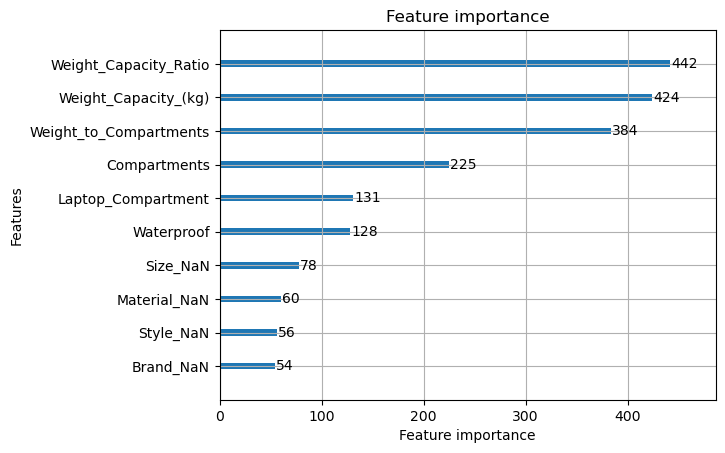

In [142]:
lgb.plot_importance(final_model, max_num_features=10)

Finally, we can make predictions for the og test set and have our predictions ready to submit to Kaggle.

In [143]:
sub = pd.read_csv("sample_submission.csv")
sub.Price = final_model.predict(test_df_imp)
sub.to_csv("submission_extra.csv",index=False)
print("Sub shape:",sub.shape)
sub

Sub shape: (200000, 2)


,id,Price
0,300000,80.916271
1,300001,82.635807
2,300002,81.959961
3,300003,81.389143
4,300004,79.280420
...,...,...
199995,499995,80.256977
199996,499996,78.637311
199997,499997,82.967073
199998,499998,81.734384


When looking to the ladder, we can see the prediction were pretty good. Of course, we can improve the results in several ways: giving more trials on optuna, trying out other models or ensembling, adding more feature engineering, filling the nans with other strategies, encoding the features with other strategies, etc.

Thanks for reading! Fernan Zl